In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_formats = ['svg']

df = pd.read_csv('data/vv_capture_2025-06-04_16-23-48/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()

# Non-VVSG equipment
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable',
                        'Internet Voting: Email',
                        'Internet Voting: Web Portal',
                        'Internet Voting: Fax',
                        'Remote Ballot Marking System: Client-Side',
                        'Remote Ballot Marking System: Server-Side']

# VVSG equipment
voting_equipment = ['Ballot Marking Device', 
                    'Hand-Fed Optical Scanner',
                    'Batch-Fed Optical Scanner',
                    'DRE-Touchscreen',
                    'DRE-Push Button',
                    'DRE-Dial',
                    'Mechanical Lever Machine',
                    'Punch Card Voting System',
                    'Hybrid BMD/Tabulator',
                    'Hybrid Optical Scan/DRE',
                    'Hybrid Optical Scan/BMD']

modern_high_n_equipment = ['Ballot Marking Device', 
                    'Hand-Fed Optical Scanner',
                    'Batch-Fed Optical Scanner',
                    'DRE-Touchscreen',
                    'DRE-Push Button',
                    'DRE-Dial',
                    # 'Mechanical Lever Machine',
                    # 'Punch Card Voting System',
                    # 'Hybrid BMD/Tabulator',
                    # 'Hybrid Optical Scan/DRE',
                    # 'Hybrid Optical Scan/BMD'
                ]

# filter only for VVSG relevant equipment
df = df[df['Equipment Type'].isin(modern_high_n_equipment)]
df = df.dropna(subset=['Final Year in Use', 'Years in Use', 'Registered Voters', 'Equipment Type'])

# merge DRE categories
df.loc[df['Equipment Type'].str.startswith('DRE'), 'Equipment Type'] = 'DRE'


/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_37693/3130632177.py:7: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/vv_capture_2025-06-04_16-23-48/cleaned_verifier_data.csv', converters={'FIPS code': str}).convert_dtypes()


In [97]:
df26 = df[df['Year'] == 2026].copy()

Text(0.5, 0, 'time $t$')

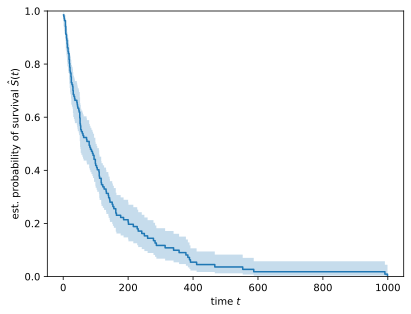

In [98]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")


In [99]:
len(df26)

11262

In [100]:
retired = df[df['Final Year in Use']]

In [101]:
len(retired)

15328

In [102]:
all = pd.concat([df26, retired])

Text(0.5, 0, 'time $t$')

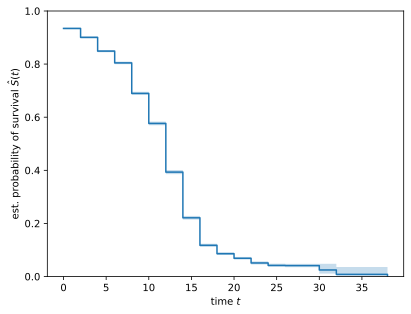

In [103]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    all['Final Year in Use'], all['Years in Use'], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")


In [104]:
from scipy.interpolate import interp1d

# Create a function that returns survival probability at any t
survival_func = interp1d(time, survival_prob, kind="previous", bounds_error=False, fill_value=(1.0, 0.0))
survival_func

In [192]:
hazard = []
for i in range(len(time) - 1):
    t_now = time[i]
    t_next = time[i + 1]
    S_now = survival_prob[i]
    S_next = survival_prob[i + 1]
    
    h_t = (S_now - S_next) / S_now if S_now > 0 else 0
    hazard.append((t_now, h_t))

hazard = np.array(hazard)  # shape: (N, 2)
# hazard[0, 1] = 0

hazard

array([[0.00000000e+00, 3.60268675e-02],
       [2.00000000e+00, 5.74647395e-02],
       [4.00000000e+00, 5.22888911e-02],
       [6.00000000e+00, 1.42783737e-01],
       [8.00000000e+00, 1.63980378e-01],
       [1.00000000e+01, 3.17913890e-01],
       [1.20000000e+01, 4.37487041e-01],
       [1.40000000e+01, 4.68369830e-01],
       [1.60000000e+01, 2.69005848e-01],
       [1.80000000e+01, 2.00779727e-01],
       [2.00000000e+01, 2.56983240e-01],
       [2.20000000e+01, 1.78947368e-01],
       [2.40000000e+01, 1.96078431e-02],
       [2.60000000e+01, 0.00000000e+00],
       [2.80000000e+01, 4.00000000e-01],
       [3.00000000e+01, 6.66666667e-01],
       [3.20000000e+01, 1.00000000e+00]])

In [177]:
hazard[0, 1]

np.float64(0.03602686749440261)

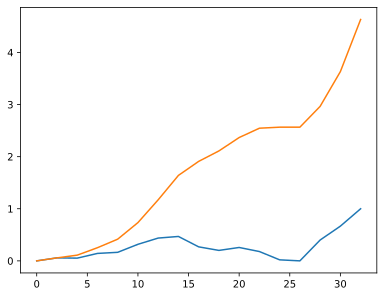

In [179]:
plt.plot(hazard[:, 0], hazard[:, 1], label='Cumulative Hazard')
# plot cumulative hazard
plt.plot(hazard[:, 0], np.cumsum(hazard[:, 1]), label='Cumulative Hazard')

In [193]:
hazard_interp = interp1d(
        hazard[:, 0], hazard[:, 1],
        kind="previous", bounds_error=False, fill_value=0.0
    )

hazard_interp(2)

array(0.05746474)

In [181]:
forecast_years = 20
cum_replacements = np.zeros(forecast_years)

# Loop over each equipment item
# for age_now in df[years_col]:
for age_now in [4, 10, 4, 4]:  # Simulating for ages 1 to 20
    survival = 1.0
    cumulative = []
    for i in range(forecast_years):
        future_age = age_now + i
        hazard = hazard_interp(future_age)
        replacement_prob = survival * hazard
        cumulative.append(replacement_prob)
        survival *= (1 - hazard)  # update survival for next year

    cum_replacements += np.cumsum(cumulative)

cum_replacements/(forecast_years-1)

# plt.plot(range(forecast_years), cum_replacements, label='Cumulative Replacements')

array([0.02498845, 0.04422576, 0.075187  , 0.09857047, 0.11928744,
       0.13550263, 0.1592466 , 0.17547085, 0.19053018, 0.19905686,
       0.20427081, 0.20708331, 0.20797234, 0.20862886, 0.20895943,
       0.20922462, 0.20949043, 0.20968792, 0.20989705, 0.21004512])

In [ ]:
hazard

5

(0.0, 1.0)

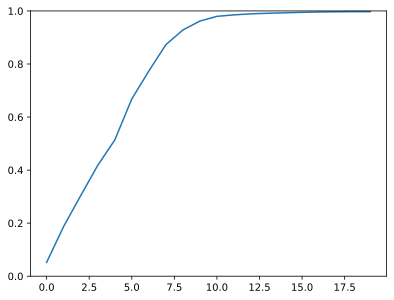

In [194]:
forecast_years = 20
cum_replacements = np.zeros(forecast_years)

# Loop over each equipment item
# for age_now in df[years_col]:
age_now = 5
# for age_now in [4, 10, 4, 4]:  # Simulating for ages 1 to 20
survival = 1.0
cumulative = []
for i in range(forecast_years):
    future_age = age_now + i
    hazard = hazard_interp(future_age)
    replacement_prob = survival * hazard
    cumulative.append(replacement_prob)
    survival *= (1 - hazard)  # update survival for next year

cum_replacements += np.cumsum(cumulative)

# cum_replacements/(forecast_years-1)

plt.plot(range(forecast_years), cum_replacements, label='Cumulative Replacements')
plt.ylim([0, 1])

In [209]:
len(np.arange(0, forecast_years + 1))


21

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_37693/102656199.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


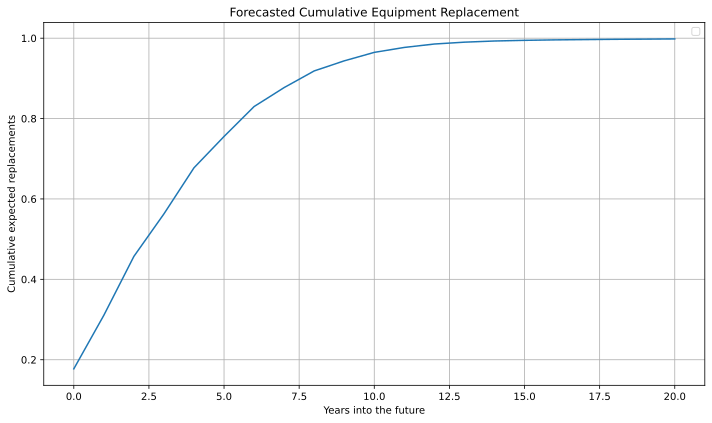

In [216]:

def cumulative_replacement_forecast(df, years, years_col, hazard_interp=hazard_interp):
    
    # Initialize cumulative sum array
    cum_replacements = np.zeros(len(years))

    
    # Loop over each equipment item. accumulate the probability in bins that the equipment will be replaced
    for age_now in df[years_col]:
        survival = 1.0
        cumulative = []
        for i in years:
            future_age = age_now + i
            hazard = hazard_interp(future_age)
            replacement_prob = survival * hazard
            cumulative.append(replacement_prob)
            survival *= (1 - hazard)  # update survival for next year

        cum_replacements += np.cumsum(cumulative)

    return pd.DataFrame({
        "Years Ahead": years,
        "Cumulative Expected Replacements": cum_replacements
    })

forecast_years = 20
years = np.arange(0, forecast_years + 1)
cumulative_df = cumulative_replacement_forecast(
    df26,
    years,
    years_col="Years in Use",
    hazard_interp=hazard_interp,
)

cumulative_df['Proportion of equipment replaced'] = cumulative_df['Cumulative Expected Replacements'] / len(df26)

cumulative_df

# Create a time axis (e.g., 2026–2057 if you want actual years)
# Plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_df['Years Ahead'], cumulative_df['Proportion of equipment replaced'])
plt.xlabel("Years into the future")
plt.ylabel("Cumulative expected replacements")
plt.title("Forecasted Cumulative Equipment Replacement")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# some kind of index issue here?

In [207]:
cumulative_df['Proportion of equipment replaced'] = cumulative_df['Cumulative Expected Replacements'] / len(df26)

In [136]:
len(df26)

11262

In [95]:
%debug

> /Users/will/Repos/voting-equipment/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py(451)_asarray_validated()
    449     if not objects_ok:
    450         if a.dtype is np.dtype('O'):
--> 451             raise ValueError('object arrays are not supported')
    452     if as_inexact:
    453         if not np.issubdtype(a.dtype, np.inexact):

> /Users/will/Repos/voting-equipment/.venv/lib/python3.13/site-packages/scipy/interpolate/_polyint.py(93)_prepare_x()
     91     def _prepare_x(self, x):
     92         """Reshape input x array to 1-D"""
---> 93         x = _asarray_validated(x, check_finite=False, as_inexact=True)
     94         x_shape = x.shape
     95         return x.ravel(), x_shape

> /Users/will/Repos/voting-equipment/.venv/lib/python3.13/site-packages/scipy/interpolate/_polyint.py(81)__call__()
     79 
     80         """
---> 81         x, x_shape = self._prepare_x(x)
     82         y = self._evaluate(x)
     83         return self._finish_y(y, x_shape)

> /v

In [60]:
def forecast_replacement(years_in_use, forecast_horizon=10):
    probs = []
    S = survival_func(years_in_use)  # survival at current age
    for i in range(1, forecast_horizon + 1):
        t_now = years_in_use + i - 1
        t_next = years_in_use + i
        S_now = survival_func(t_now)
        S_next = survival_func(t_next)
        prob_replacement = (S_now - S_next) / S
        probs.append(prob_replacement)
    return probs  # one per year into the future

# Apply to all rows
forecast_horizon = 10
forecast_matrix = df26["Years in Use"].apply(lambda y: forecast_replacement(y, forecast_horizon))


/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_37693/672675504.py:9: RuntimeWarning: invalid value encountered in divide
  prob_replacement = (S_now - S_next) / S


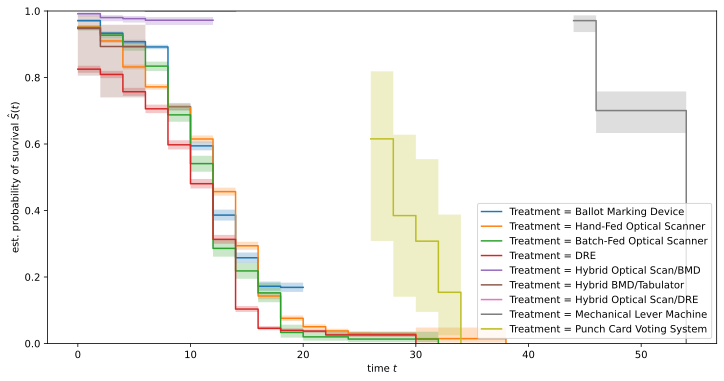

In [62]:
plt.figure(figsize=(12, 6))
for treatment_type in (all['Equipment Type'].unique()):
    mask_treat = all["Equipment Type"] == treatment_type
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        all["Final Year in Use"][mask_treat],
        all["Years in Use"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Treatment = {treatment_type}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="lower right")


In [ ]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored


set_config(display="text")  # displays text representation of estimators

all['Equipment Type'] = all['Equipment Type'].astype('category')
data_x = all[['Registered Voters']]

data_y = np.array(
    list(zip(all["Final Year in Use"].astype(bool), all["Years in Use"].astype(float))),
    dtype=[("Status", "?"), ("Survival_in_years", "<f8")]
)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)


prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_years"], prediction)
f"{result[0]:.5f}"

# registered voters is not predictive on its own.

'0.48513'

In [99]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored


set_config(display="text")  # displays text representation of estimators

all['Equipment Type'] = all['Equipment Type'].astype('category')
data_x = OneHotEncoder().fit_transform(all[['Equipment Type']])

data_y = np.array(
    list(zip(all["Final Year in Use"].astype(bool), all["Years in Use"].astype(float))),
    dtype=[("Status", "?"), ("Survival_in_years", "<f8")]
)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)


prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_years"], prediction)
f"{result[0]:.5f}"

'0.58516'

In [101]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored


set_config(display="text")  # displays text representation of estimators

all['Equipment Type'] = all['Equipment Type'].astype('category')
data_x = OneHotEncoder().fit_transform(all[['Equipment Type', 'Registered Voters']])

data_y = np.array(
    list(zip(all["Final Year in Use"].astype(bool), all["Years in Use"].astype(float))),
    dtype=[("Status", "?"), ("Survival_in_years", "<f8")]
)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)


prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_years"], prediction)
f"{result[0]:.5f}"

/Users/will/Repos/voting-equipment/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=9.94318e-17): result may not be accurate.
  delta = solve(
/Users/will/Repos/voting-equipment/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.65806e-17): result may not be accurate.
  delta = solve(
/Users/will/Repos/voting-equipment/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.34575e-17): result may not be accurate.
  delta = solve(
/Users/will/Repos/voting-equipment/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=4.95076e-18): result may not be accurate.
  delta = solve(
/Users/will/Repos/voting-equipment/.venv/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.82129e-18): resul

'0.58301'

In [102]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

Equipment Type=DRE                          0.554269
Equipment Type=Hybrid Optical Scan/BMD      0.511956
Equipment Type=Mechanical Lever Machine     0.508316
Equipment Type=Hybrid Optical Scan/DRE      0.502772
Equipment Type=Hand-Fed Optical Scanner     0.500602
Equipment Type=Punch Card Voting System     0.500514
Equipment Type=Hybrid BMD/Tabulator         0.500144
Equipment Type=Batch-Fed Optical Scanner    0.499853
Registered Voters                           0.485127
dtype: float64

'0.58301'

In [97]:
c_index = estimator.score(data_x, data_y)
f"{c_index:.5f}"

'0.58301'

<Axes: >

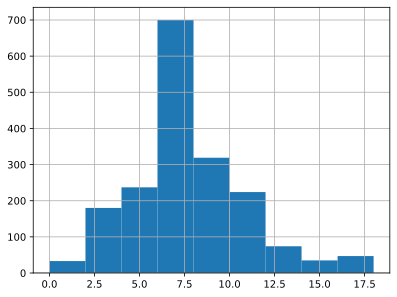

In [110]:
df26[df26['Registered Voters'] > 5e4]['Years in Use'].hist(bins=range(0,20,2))

<Axes: >

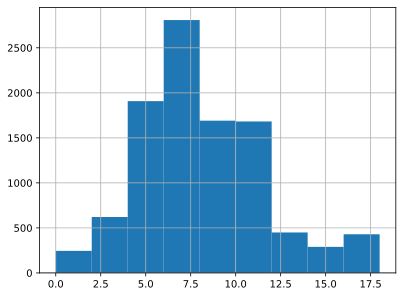

In [111]:
df26[df26['Registered Voters'] < 5e4]['Years in Use'].hist(bins=range(0,20,2))

In [112]:
df26[df26['Registered Voters'] < 5e4]['Years in Use'].mean()

np.float64(7.596384962984328)

In [113]:
df26[df26['Registered Voters'] > 5e4]['Years in Use'].mean()

np.float64(7.224489795918367)

In [126]:
avg = df26.groupby('FIPS code').agg({
    'Registered Voters': 'mean',
    'Years in Use': 'mean'
}).reset_index()

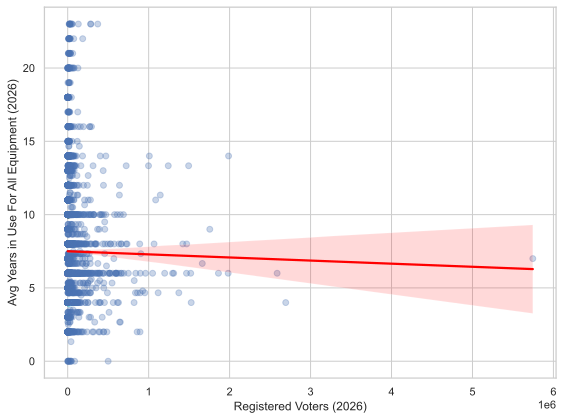

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot style
sns.set(style="whitegrid")

# Create the scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=avg,
    x="Registered Voters",
    y="Years in Use",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"},
    ci=95  # Confidence interval for regression line
)

# plt.title("Impact of Registered Voters on Equipment Years in Use")
plt.xlabel("Registered Voters (2026)")
plt.ylabel("Avg Years in Use For All Equipment (2026)")
plt.tight_layout()
plt.show()


In [129]:
avg.sort_values('Registered Voters', ascending=False).head(10)

,FIPS code,Registered Voters,Years in Use
176,0603700000,5745214.0,7.0
3840,4820100000,2693055.0,4.0
75,0401300000,2587196.0,6.0
6371,7200000000,1987317.0,14.0
194,0607300000,1982264.0,6.0
187,0605900000,1862010.0,6.0
2703,3200300000,1755063.0,9.0
742,1703100000,1662527.0,6.666667
495,1208600000,1525443.0,4.0
798,1714000000,1519528.0,6.0


<Axes: >

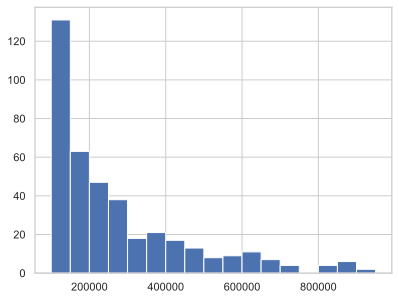

In [128]:
avg['Registered Voters'].hist(bins=range(100000,1000000,50000))

In [123]:
df26[df26['Registered Voters'] > 800000]

,Year,FIPS code,State,Jurisdiction,Registered Voters,Equipment Type,Manufacturer,Model,First Year in Use,Years in Use,New Equipment,Final Year in Use,QR/Barcode,VVPAT,Election Day Standard,Election Day Accessible,Early Voting Standard,Early Voting Accessible,Mail Ballot/Absentee Equipment,Notes on usage
3154,2026,0401300000,Arizona,Maricopa County,2587196,Ballot Marking Device,Dominion,ImageCast X BMD,2020,6,False,False,True,<NA>,False,True,False,True,False,<NA>
3165,2026,0401300000,Arizona,Maricopa County,2587196,Batch-Fed Optical Scanner,Dominion,ImageCast Central,2020,6,False,False,<NA>,<NA>,False,False,False,False,True,<NA>
3185,2026,0401300000,Arizona,Maricopa County,2587196,Hand-Fed Optical Scanner,Dominion,ImageCast Precinct,2020,6,False,False,<NA>,<NA>,True,False,True,False,False,<NA>
6605,2026,0600100000,California,Alameda County,961304,Ballot Marking Device,Dominion,ImageCast X BMD,2020,6,False,False,True,<NA>,False,True,False,True,False,<NA>
6616,2026,0600100000,California,Alameda County,961304,Batch-Fed Optical Scanner,Dominion,ImageCast Central,2020,6,False,False,<NA>,<NA>,True,False,True,False,True,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211218,2026,5105900000,Virginia,Fairfax County,820121,Hand-Fed Optical Scanner,ES&S,DS300,2026,0,True,False,<NA>,<NA>,True,False,True,False,False,<NA>
216210,2026,5303300000,Washington,King County,1421687,Ballot Marking Device,Clear Ballot,ClearAccess,2018,8,False,False,False,<NA>,False,True,False,True,False,<NA>
216221,2026,5303300000,Washington,King County,1421687,Batch-Fed Optical Scanner,Clear Ballot,ClearCount,2018,8,False,False,<NA>,<NA>,True,False,True,False,True,<NA>
279766,2026,7200000000,Puerto Rico,Puerto Rico,1987317,Ballot Marking Device,IVS,Inspire Vote By Phone,2008,18,False,False,True,<NA>,False,True,False,True,False,<NA>
